In [1]:
import pandas as pd
import numpy as np
import sqlite3
import scrapbook as sb

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter
from pandas.plotting import scatter_matrix

plt.style.use('ggplot')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 20]

%matplotlib inline

D:\anaconda3\envs\mfe-preprogram\lib\site-packages\papermill\iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


In [2]:
token = 'BTC'
from_date = '2021-11-05'
to_date = '2021-11-11'
connection_string = 'sqlite:///../../../Lectures/Lecture 4/data/data.db'


In [3]:
# Parameters
from_date = "2021-12-06 00:00:00"
to_date = "2021-12-13 00:00:00"
token = "SOL"
connection_string = "sqlite:///../../../Lectures/Lecture 4/data/data.db"


In [4]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', connection_string)
prices['ts'] = pd.to_datetime(prices['ts'])

prices.set_index('ts', inplace=True)

prices

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-12-06 00:00:00,190.737,198.094,189.902,196.687,116947.399,2.284420e+07,SOL,SOL
2021-12-06 01:00:00,196.758,197.466,187.583,190.050,105988.194,2.022580e+07,SOL,SOL
2021-12-06 02:00:00,190.063,193.134,188.419,192.418,65962.884,1.259166e+07,SOL,SOL
2021-12-06 03:00:00,192.419,194.684,191.892,192.417,53265.687,1.028847e+07,SOL,SOL
2021-12-06 04:00:00,192.475,195.473,191.478,193.592,47640.389,9.226364e+06,SOL,SOL
...,...,...,...,...,...,...,...,...
2021-12-12 19:00:00,175.490,176.950,174.910,175.420,81742.264,1.438721e+07,SOL,SOL
2021-12-12 20:00:00,175.410,176.470,174.380,174.570,57873.549,1.014901e+07,SOL,SOL
2021-12-12 21:00:00,174.530,175.510,173.950,174.540,43966.440,7.689166e+06,SOL,SOL


# Calculate the hourly return by timestamp

In [5]:
prices['return'] = np.log(prices['close'] / prices['close'].shift(1))
prices.head()

,open,high,low,close,volume,volumeUSD,token,chain,return
ts,,,,,,,,,
2021-12-06 00:00:00,190.737,198.094,189.902,196.687,116947.399,2.284420e+07,SOL,SOL,NaN
2021-12-06 01:00:00,196.758,197.466,187.583,190.050,105988.194,2.022580e+07,SOL,SOL,-0.034326
2021-12-06 02:00:00,190.063,193.134,188.419,192.418,65962.884,1.259166e+07,SOL,SOL,0.012383
2021-12-06 03:00:00,192.419,194.684,191.892,192.417,53265.687,1.028847e+07,SOL,SOL,-0.000005
2021-12-06 04:00:00,192.475,195.473,191.478,193.592,47640.389,9.226364e+06,SOL,SOL,0.006088


# Calculate the hourly volatility

In [6]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

prices['volatility'] = vol_ohlc(prices)
prices.head(20)

,open,high,low,close,volume,volumeUSD,token,chain,return,volatility
ts,,,,,,,,,,
2021-12-06 00:00:00,190.737,198.094,189.902,196.687,116947.399,2.284420e+07,SOL,SOL,NaN,NaN
2021-12-06 01:00:00,196.758,197.466,187.583,190.050,105988.194,2.022580e+07,SOL,SOL,-0.034326,NaN
2021-12-06 02:00:00,190.063,193.134,188.419,192.418,65962.884,1.259166e+07,SOL,SOL,0.012383,NaN
2021-12-06 03:00:00,192.419,194.684,191.892,192.417,53265.687,1.028847e+07,SOL,SOL,-0.000005,NaN
2021-12-06 04:00:00,192.475,195.473,191.478,193.592,47640.389,9.226364e+06,SOL,SOL,0.006088,NaN
2021-12-06 05:00:00,193.466,196.670,193.465,194.913,32842.741,6.404835e+06,SOL,SOL,0.006800,NaN
2021-12-06 06:00:00,194.913,196.114,190.582,190.582,46860.328,9.051286e+06,SOL,SOL,-0.022471,NaN
2021-12-06 07:00:00,190.682,192.942,187.520,187.784,46879.632,8.930761e+06,SOL,SOL,-0.014790,NaN
2021-12-06 08:00:00,187.780,188.591,183.210,185.300,71948.075,1.335658e+07,SOL,SOL,-0.013316,NaN


# Calculate maximum drawdown

In [7]:
prices['maxdrawdown'] = prices['close'] / prices['high'].cummax() - 1
prices['maxdrawdown'] = prices['maxdrawdown'].cummin()

prices.head(20)

,open,high,low,close,volume,volumeUSD,token,chain,return,volatility,maxdrawdown
ts,,,,,,,,,,,
2021-12-06 00:00:00,190.737,198.094,189.902,196.687,116947.399,2.284420e+07,SOL,SOL,NaN,NaN,-0.007103
2021-12-06 01:00:00,196.758,197.466,187.583,190.050,105988.194,2.022580e+07,SOL,SOL,-0.034326,NaN,-0.040607
2021-12-06 02:00:00,190.063,193.134,188.419,192.418,65962.884,1.259166e+07,SOL,SOL,0.012383,NaN,-0.040607
2021-12-06 03:00:00,192.419,194.684,191.892,192.417,53265.687,1.028847e+07,SOL,SOL,-0.000005,NaN,-0.040607
2021-12-06 04:00:00,192.475,195.473,191.478,193.592,47640.389,9.226364e+06,SOL,SOL,0.006088,NaN,-0.040607
2021-12-06 05:00:00,193.466,196.670,193.465,194.913,32842.741,6.404835e+06,SOL,SOL,0.006800,NaN,-0.040607
2021-12-06 06:00:00,194.913,196.114,190.582,190.582,46860.328,9.051286e+06,SOL,SOL,-0.022471,NaN,-0.040607
2021-12-06 07:00:00,190.682,192.942,187.520,187.784,46879.632,8.930761e+06,SOL,SOL,-0.014790,NaN,-0.052046
2021-12-06 08:00:00,187.780,188.591,183.210,185.300,71948.075,1.335658e+07,SOL,SOL,-0.013316,NaN,-0.064585


# Plot

In [8]:
def series_plot(data, events=None, ax=None):
    data.plot(ax=ax)
    
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)

    if events is not None:
        ymin, ymax = ax.get_ylim()
        text_pos = 1
        
        for idx, row in events.loc[data.index[0]:data.index[-1]].iterrows():
            if row.impact == 1:
                text_pos = (text_pos + 1) % 2
                x = idx
                ax.axvline(x, color='0.2', linestyle=':')
                ax.text(x, ymin, row.event, rotation=90, color='0.2')    
            elif row.impact == 2:
                text_pos = (text_pos + 1) % 2
                x = idx
                ax.axvline(x, color='0.6', linestyle=':')
                ax.text(x, ymin, row.event, rotation=90, color='0.6')
                
                

In [9]:
%%capture

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

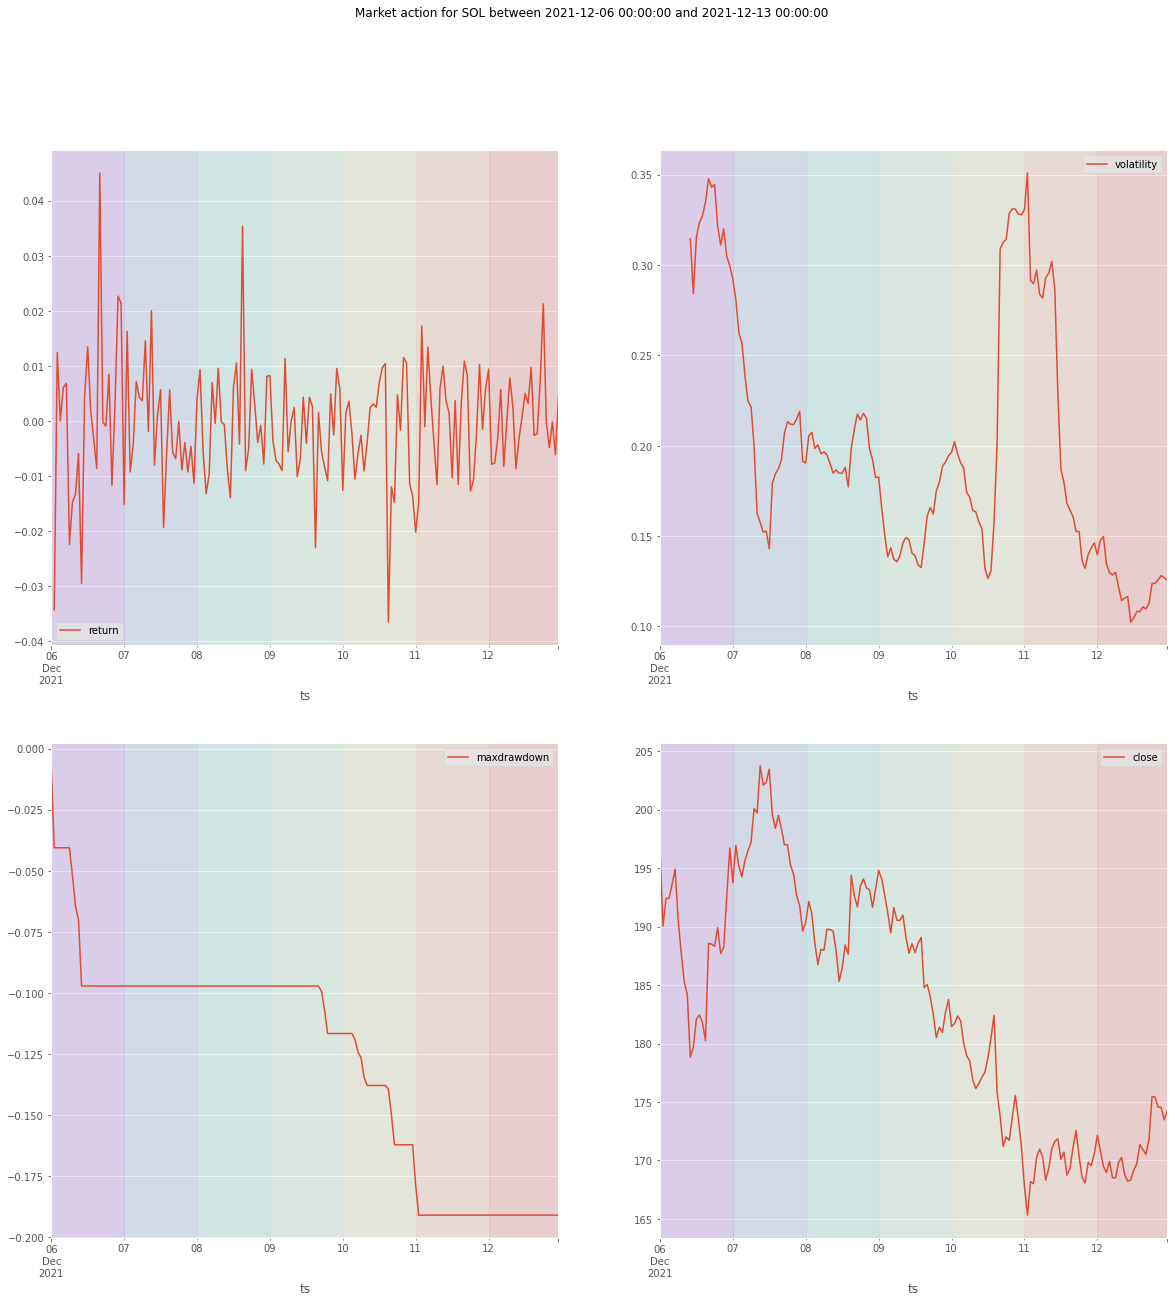

In [10]:
series_plot(prices[['return']], ax=ax[0, 0])
series_plot(prices[['volatility']], ax=ax[0, 1])
series_plot(prices[['maxdrawdown']], ax=ax[1, 0])
series_plot(prices[['close']], ax=ax[1, 1])
fig.suptitle(f'Market action for {token} between {from_date} and {to_date}')
fig

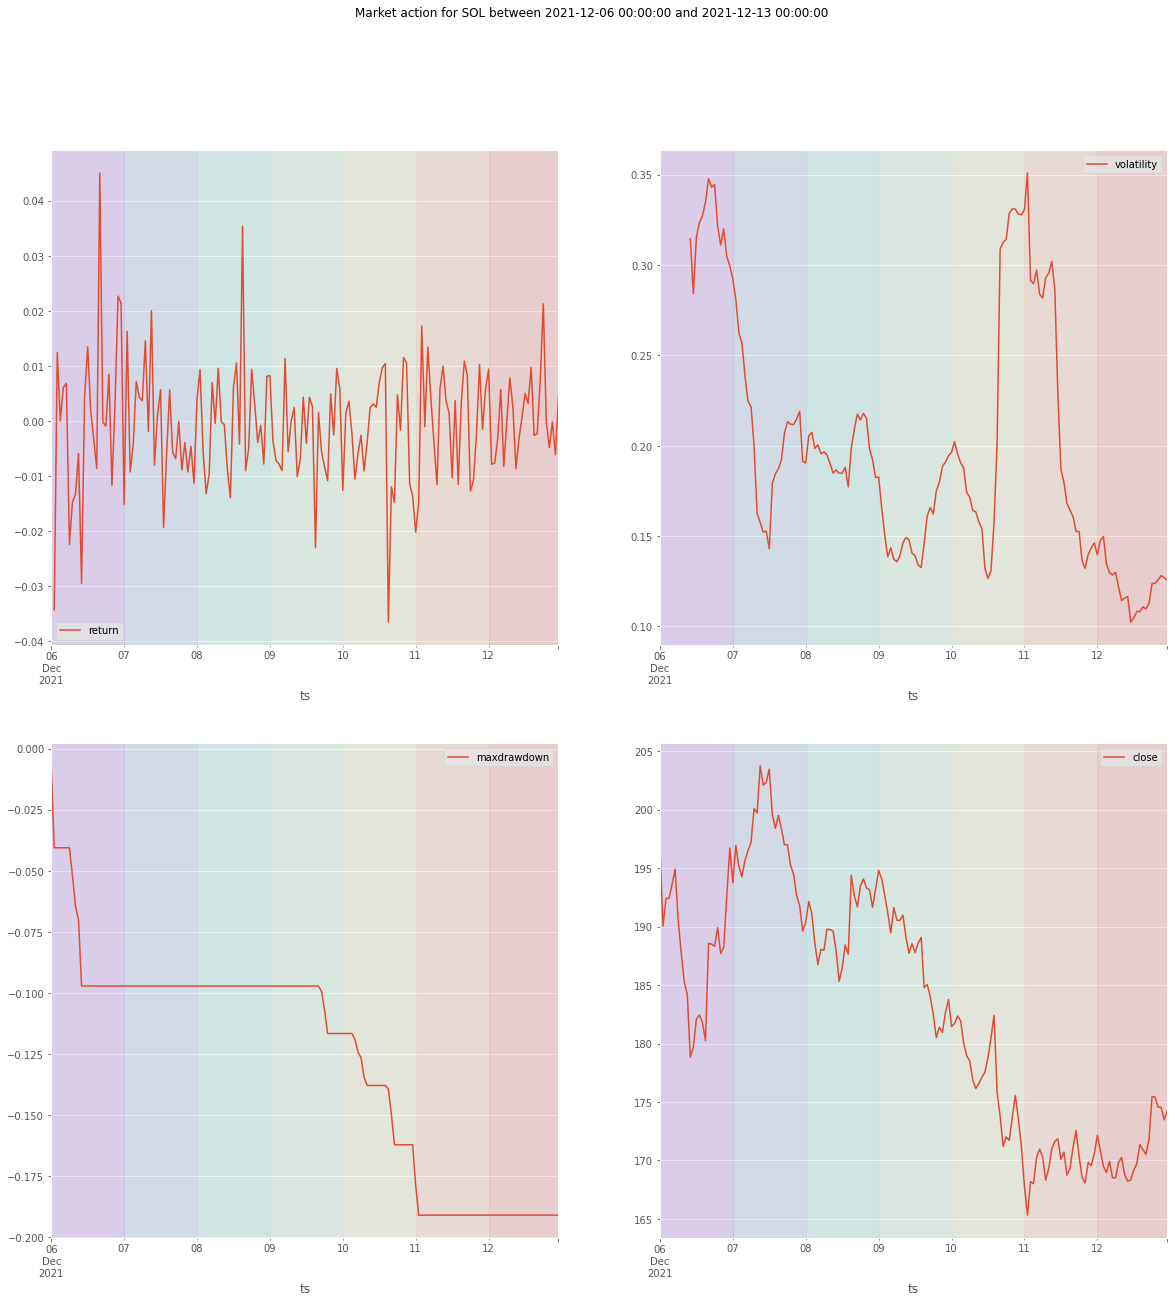

In [11]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)